<a href="https://colab.research.google.com/github/ziatdinovmax/gpax/blob/main/examples/simpleGP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q git+https://github.com/ziatdinovmax/gpax.git

Imports:

In [ ]:
import gpax
import numpy as np
import matplotlib.pyplot as plt

gpax.utils.enable_x64()

Generate some noisy observations (aka 'training data'):

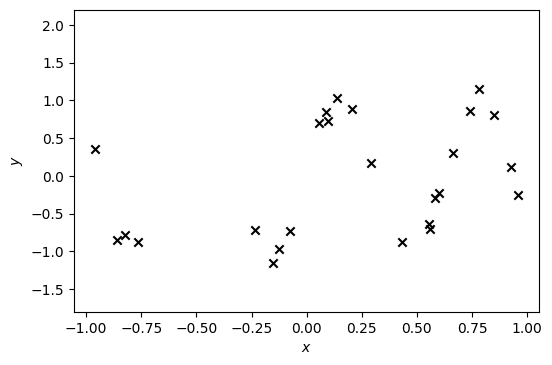

In [ ]:
np.random.seed(0)

NUM_INIT_POINTS = 25 # number of observation points
NOISE_LEVEL = 0.1 # noise level

# Generate noisy data from a known function
f = lambda x: np.sin(10*x)

X = np.random.uniform(-1., 1., NUM_INIT_POINTS)
y = f(X) + np.random.normal(0., NOISE_LEVEL, NUM_INIT_POINTS)

# Plot generated data
plt.figure(dpi=100)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.scatter(X, y, marker='x', c='k', zorder=1, label='Noisy observations')
plt.ylim(-1.8, 2.2);

In [ ]:
# Get random number generator keys (see JAX documentation for why it is neccessary)
rng_key, rng_key_predict = gpax.utils.get_keys()

# initialize model
gp_model = gpax.ExactGP(1, kernel='RBF')
# run MCMC to obtain posterior samples
gp_model.fit(rng_key, X, y, num_chains=1)

sample: 100%|██████████| 4000/4000 [00:15<00:00, 251.08it/s, 7 steps of size 4.47e-01. acc. prob=0.94]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.17      0.03      0.16      0.12      0.22    911.52      1.00
    k_scale      1.22      0.91      0.96      0.29      2.25    735.65      1.00
      noise      0.03      0.02      0.03      0.01      0.06   1089.18      1.00



Now let's use our 'trained' model to obtain predictive posterior distribution on new/'test' data:

In [ ]:
# prepare test inputs
X_test = np.linspace(-1, 1, 100)
# Get GP prediction
y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test, n=200)

Plot results:

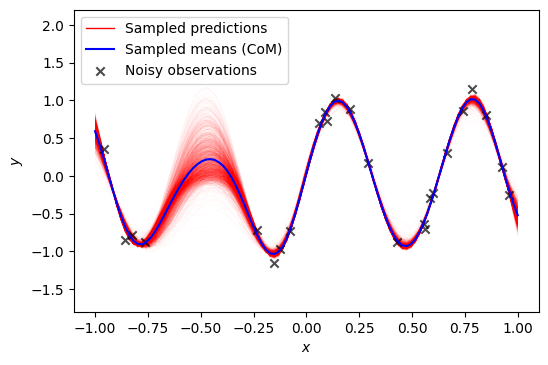

In [ ]:
_, ax = plt.subplots(dpi=100)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.scatter(X, y, marker='x', c='k', zorder=1, label="Noisy observations", alpha=0.7)
for y1 in y_sampled:
    ax.plot(X_test, y1.mean(0), lw=.1, zorder=0, c='r', alpha=.1)
l, = ax.plot(X_test, y_sampled[0].mean(0), lw=1, c='r', alpha=1, label="Sampled predictions")
ax.plot(X_test, y_pred, lw=1.5, zorder=1, c='b', label='Sampled means (CoM)')
ax.legend(loc='upper left')
l.set_alpha(0)
ax.set_ylim(-1.8, 2.2);

It is also common in literature to draw the GP uncertainty (here defined as standard deviation across all sampled predictions) as a $2\sigma$ shaded region around the GP posterior mean:

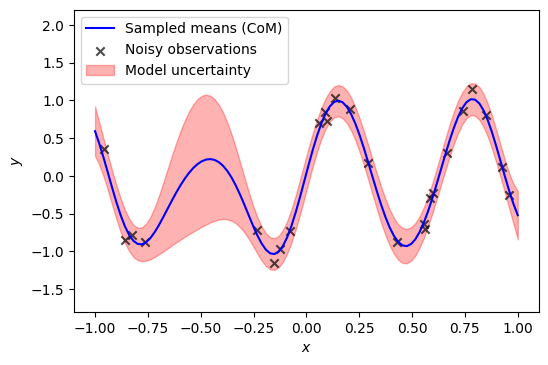

In [ ]:
_, ax = plt.subplots(dpi=100)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.scatter(X, y, marker='x', c='k', zorder=2, label="Noisy observations", alpha=0.7)
ax.plot(X_test, y_pred, lw=1.5, zorder=2, c='b', label='Sampled means (CoM)')
ax.fill_between(X_test, y_pred - y_sampled.std(axis=(0,1)), y_pred + y_sampled.std(axis=(0,1)),
                color='r', alpha=0.3, label="Model uncertainty")
ax.legend(loc='upper left')
ax.set_ylim(-1.8, 2.2);

Now let's do the same but with periodic kernel. We can specify custom priors for the periodic kernel parameters using NumPyro distributions. It is always a good idea to visualize a distribution before using it as a prior. GPax has a convenient utility function for this:

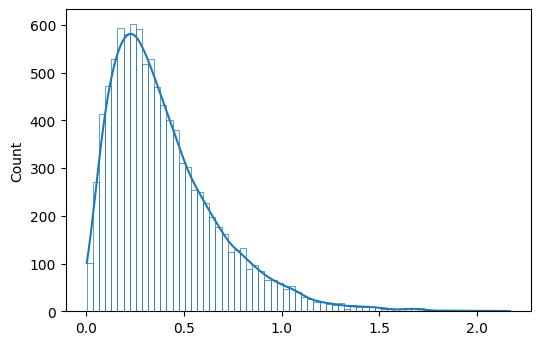

In [ ]:
import numpyro

d = numpyro.distributions.Gamma(2, 5)
gpax.utils.dviz(d, samples=10000)

We are going to compare how the periodic kernel behaves when we set a period to a constant value and when it is inferred from the data. For this, we define a function that returns a kernel prior for each value of period that we pass as an argument. When we pass a None value, the period is sampled from the prescribed prior distribution.

In [ ]:
def get_kernel_prior(p=None):

    def kernel_prior():
        # Sample kernel length and output scales
        length = numpyro.sample("k_length", numpyro.distributions.Gamma(2, 5))
        scale = numpyro.sample("k_scale", numpyro.distributions.LogNormal(0, 1))
        # Sample period or set it to a constant value
        if p:
            period = numpyro.deterministic("period", p)
        else:
            period = numpyro.sample("period", numpyro.distributions.Gamma(2, 5))
        # Hyperparameters are returned as dictionary
        return {"k_length": length, "k_scale": scale, "period": period}
    
    return kernel_prior

Infer the GP kernel hyperparameters using the custom kernel prior and make a prediction on 'test' inputs:

sample: 100%|██████████| 4000/4000 [00:09<00:00, 409.27it/s, 7 steps of size 5.40e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.34      0.30      0.24      0.01      0.76   1672.28      1.00
   k_scale      0.28      0.24      0.23      0.03      0.53   1299.81      1.00
     noise      0.61      0.22      0.58      0.31      0.94   1658.78      1.00
    period      0.30      0.00      0.30      0.30      0.30      0.50      1.00



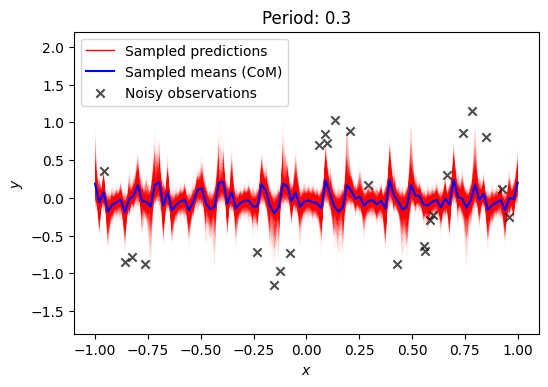

sample: 100%|██████████| 4000/4000 [00:08<00:00, 454.87it/s, 7 steps of size 6.01e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      1.13      0.33      1.10      0.64      1.69   1576.93      1.00
   k_scale      0.74      0.56      0.58      0.17      1.33    960.05      1.00
     noise      0.07      0.03      0.07      0.03      0.11   1220.55      1.00
    period      0.60      0.00      0.60      0.60      0.60      0.50      1.00



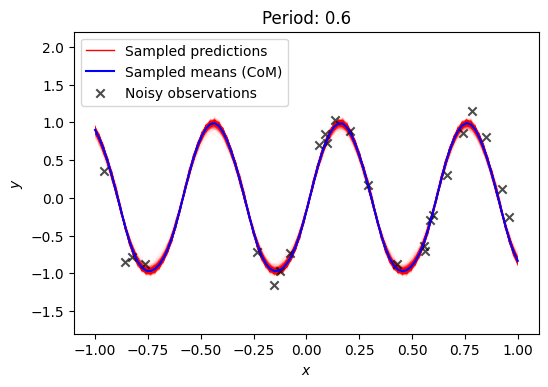

sample: 100%|██████████| 4000/4000 [00:09<00:00, 431.13it/s, 7 steps of size 4.75e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.43      0.28      0.39      0.01      0.78   1487.66      1.00
   k_scale      0.33      0.32      0.25      0.03      0.63    872.96      1.00
     noise      0.58      0.20      0.55      0.28      0.86   1481.98      1.00
    period      1.00      0.00      1.00      1.00      1.00       nan       nan



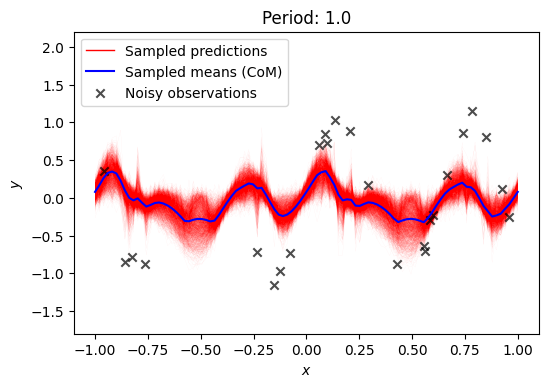

sample: 100%|██████████| 4000/4000 [00:11<00:00, 346.43it/s, 7 steps of size 6.01e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      1.31      0.36      1.27      0.73      1.86   1600.54      1.00
   k_scale      0.76      0.53      0.61      0.18      1.38   1490.32      1.00
     noise      0.02      0.01      0.02      0.01      0.04   1232.18      1.00
    period      0.62      0.01      0.62      0.62      0.63   1221.70      1.00



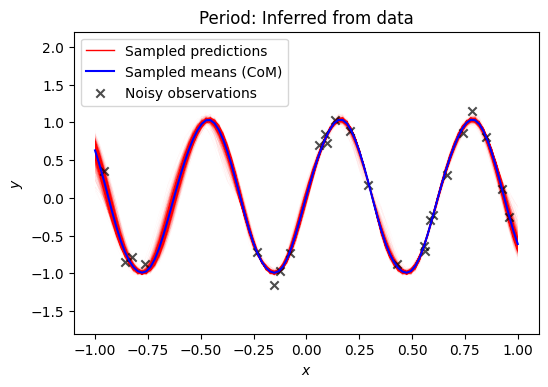

In [ ]:
for p in [0.3, 0.6, 1.0, None]:
    # Initialize model
    gp_model = gpax.ExactGP(1, kernel='Periodic', kernel_prior=get_kernel_prior(p))
    # Run MCMC to obtain posterior samples
    gp_model.fit(rng_key, X, y, num_chains=1)
    # Get GP prediction
    y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test, n=200)

    # Plot results
    _, ax = plt.subplots(dpi=100)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.scatter(X, y, marker='x', c='k', zorder=1, label="Noisy observations", alpha=0.7)
    for y1 in y_sampled:
        ax.plot(X_test, y1.mean(0), lw=.1, zorder=0, c='r', alpha=.1)
    l, = ax.plot(X_test, y_sampled[0].mean(0), lw=1, c='r', alpha=1, label="Sampled predictions")
    ax.plot(X_test, y_pred, lw=1.5, zorder=1, c='b', label='Sampled means (CoM)')
    ax.legend(loc='upper left')
    l.set_alpha(0)
    ax.set_ylim(-1.8, 2.2)
    ax.set_title("Period: {}".format(p if p else "Inferred from data"))
    plt.show()

One can see that we get a more reliable result when the period value is inferred from data. Overall, we can use the GP kernel function to incorporate some amount of prior knowledge into the GP modeling.